<a href="https://colab.research.google.com/github/whalez82/cnn-fruit-classification/blob/main/notebooks/fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-based Fruit Classification

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
import cv2

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. set the paths
train_path = '/content/drive/MyDrive/Colab Notebooks/data 3/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/data 3/test'

Mounted at /content/drive


## 1. Data Load

In [ ]:
def load_fruit_data(folder_path):
  '''
  Loads fruit images from the given folder.
  Returns image data, labels, class names, and file paths.

  Parameters
  ----------
  folder_path : str
    Root path containing class-named subfolders.

  Returns
  -------
  images (np.array): Array of image data in original sizes.
  labels (np.array): Corresponding class labels as integers.
  class_names (list): Sorted list of fruit class names.
  file_paths (list): Full paths to each image file.
  '''
  images = [] # List to store image data
  labels = [] # List to store corresponding class labels.
  file_paths = [] # List to store image file paths.

  # Get sorted list of class names (folder names)
  class_names = sorted(os.listdir(folder_path))

  # Create mapping between class names and integer labels
  class_to_index = {name: i for i, name in enumerate(class_names)}
  index_to_class = {i: name for name, i in class_to_index.items()}

  # Loop over each class folder
  for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(folder_path, class_name) # e.g. '/content/drive/MyDrive/Colab Notebooks/data/train/Banana'

    # Skip if it's not a directory
    if not os.path.isdir(class_folder):
      continue

    # Loop through each image file in the class folder
    for img_name in os.listdir(class_folder):
      img_path = os.path.join(class_folder, img_name)

      # Read the image using OpenCV
      img = cv2.imread(img_path)

      # if the image is read successfully
      if img is not None:
        images.append(img)
        labels.append(class_to_index[class_name])
        file_paths.append(img_path)

  # Convert lists to numpy arrays
  return np.array(images), np.array(labels), class_names, file_paths, class_to_index, index_to_class





In [ ]:
X_train, y_train, class_names, train_img_path, class_to_index, index_to_class = load_fruit_data(train_path)
X_test, y_test, _, test_img_path, _, _ = load_fruit_data(test_path)

In [ ]:
# Check the shape of the image data and labels
print("=== [Data Structure Summary] ===\n")

# Image data shape and type
print(f"X_train shape         : {X_train.shape}")
print(f"X_test shape          : {X_test.shape}")
print(f"Data type of X_train  : {X_train.dtype}")
print(f"Data type of X_test   : {X_test.dtype}\n")

# Label data shape, type, and distribution
print(f"y_train shape         : {y_train.shape}")
print(f"Data type of y_train  : {y_train.dtype}")
print(f"Unique y_train labels : {np.unique(y_train)}")
print(f"Total y_train samples : {len(y_train)}\n")

# Class info and mapping
print(f"Number of classes     : {len(class_names)}")
print(f"Class names           : {class_names}")
print(f"Class to index mapping: {class_to_index}")
print(f"Index to class mapping: {index_to_class}")

=== [Data Structure Summary] ===

X_train shape         : (6044, 100, 100, 3)
X_test shape          : (663, 100, 100, 3)
Data type of X_train  : uint8
Data type of X_test   : uint8

y_train shape         : (6044,)
Data type of y_train  : int64
Unique y_train labels : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Total y_train samples : 6044

Number of classes     : 14
Class names           : ['Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cherry', 'Corn', 'Kiwi', 'Mango', 'Orange', 'Pineapple', 'Strawberry', 'Watermelon']
Class to index mapping: {'Apple Granny Smith': 0, 'Apricot': 1, 'Avocado': 2, 'Banana': 3, 'Blueberry': 4, 'Cactus fruit': 5, 'Cherry': 6, 'Corn': 7, 'Kiwi': 8, 'Mango': 9, 'Orange': 10, 'Pineapple': 11, 'Strawberry': 12, 'Watermelon': 13}
Index to class mapping: {0: 'Apple Granny Smith', 1: 'Apricot', 2: 'Avocado', 3: 'Banana', 4: 'Blueberry', 5: 'Cactus fruit', 6: 'Cherry', 7: 'Corn', 8: 'Kiwi', 9: 'Mango', 10: 'Orange', 11: 'Pinea

In [ ]:
# Double check all image sizes are the same
shapes = [img.shape for img in X_train]
unique_shapes = set(shapes)
print(f"Number of unique shapes: {len(unique_shapes)}")
print(f"Unique image shapes: {unique_shapes}")

Number of unique shapes: 1
Unique image shapes: {(100, 100, 3)}


In [ ]:
# # Optional resize BEFORE train/val split
# RESIZE_DIM = (50, 50)  # or 64, 64 / 50, 50 / 32, 32 etc.

# X_train = np.array([cv2.resize(img, RESIZE_DIM) for img in X_train])
# X_test  = np.array([cv2.resize(img, RESIZE_DIM) for img in X_test])

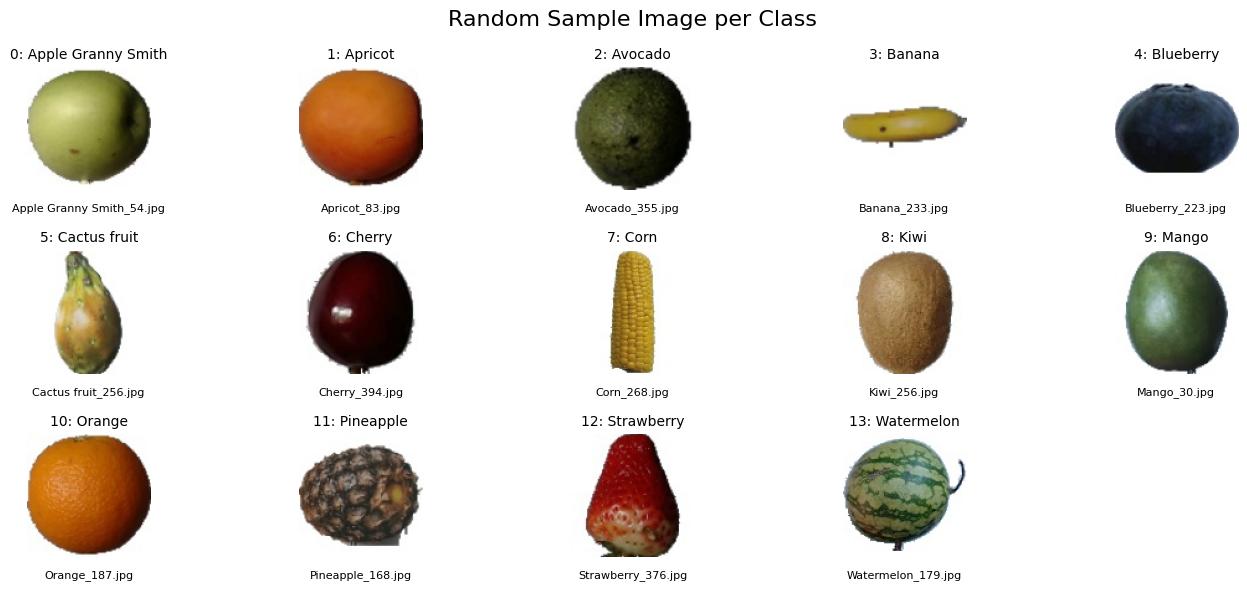

In [ ]:
# Check sample image
# Create a figure with 14x6 size
plt.figure(figsize=(14, 6))

for class_idx, class_name in enumerate(class_names):
  class_folder = os.path.join(train_path, class_name)
  img_list = os.listdir(class_folder)

  # Skip if folder is empty
  if len(img_list) == 0:
    continue

  # Pick a random image from the class folder
  img_name = random.choice(img_list)
  img_path = os.path.join(class_folder, img_name)

  # Load and show image
  img = cv2.imread(img_path)
  if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 5, class_idx + 1)
    plt.imshow(img_rgb)

    # Display class index + class name as title
    title = f"{class_idx}: {class_name}"

    # show file name below the image
    plt.title(title, fontsize=10)
    # Custom text (image filename) below image using plt.text
    plt.text(
        0.5, -0.15,  # (x, y) in axes fraction coordinates
        img_name,    # Text to display (e.g., Banana_119.jpg)
        fontsize=8,
        ha='center', # Horizontal alignment
        va='center', # Vertical alignment
        transform=plt.gca().transAxes  # Use axis coordinates
    )
    plt.axis('off')

plt.suptitle("Random Sample Image per Class", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Count how many images each class has
class_counts = pd.Series(y_train).value_counts().sort_index()

# Create a summary DataFrame for display
eda_summary_df = pd.DataFrame({
    "Class Index": class_counts.index,
    "Class (Fruit) Name": [index_to_class[i] for i in class_counts.index],
    "Number of Images": class_counts.values,
    "Percentage (%)": (class_counts.values / len(y_train) * 100).round(2)
})

display(eda_summary_df)

,Class Index,Class (Fruit) Name,Number of Images,Percentage (%)
0,0,Apple Granny Smith,451,7.46
1,1,Apricot,471,7.79
2,2,Avocado,381,6.30
3,3,Banana,441,7.30
4,4,Blueberry,411,6.80
5,5,Cactus fruit,441,7.30
6,6,Cherry,451,7.46
7,7,Corn,401,6.63
8,8,Kiwi,421,6.97
9,9,Mango,431,7.13


/tmp/ipython-input-2145592665.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


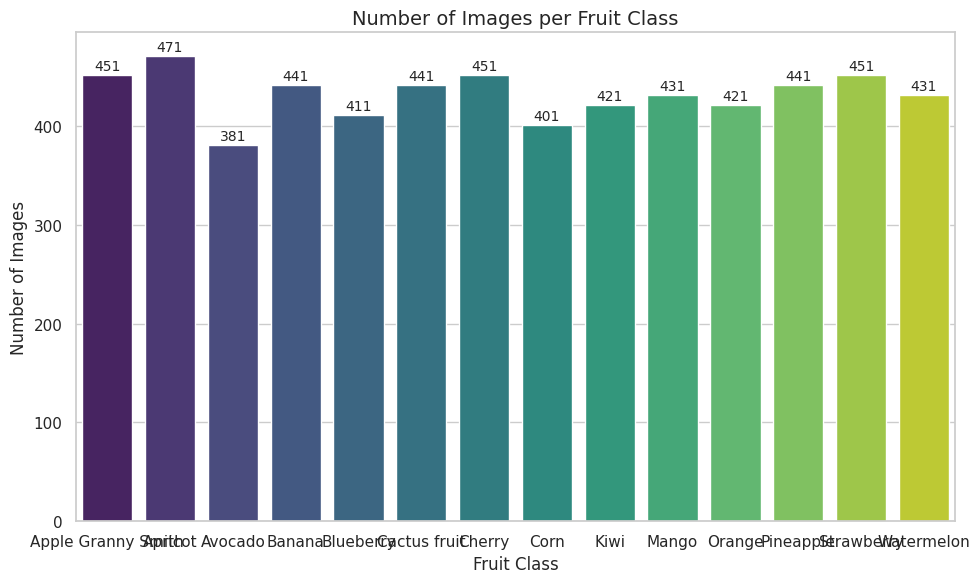

In [ ]:
# Set visual style for better readability
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(
    data=eda_summary_df,
    x="Class (Fruit) Name",
    y="Number of Images",
    palette="viridis"
)

# Add value lables on top of each bar
for index, row in eda_summary_df.iterrows():
  plt.text(
      x=index,
      y=row["Number of Images"] + 5,
      s=str(row["Number of Images"]),
      ha='center',
      fontsize=10
  )

# Title and labels
plt.title("Number of Images per Fruit Class", fontsize=14)
plt.xlabel("Fruit Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Step 4: Splitting the Dataset and Preparing Input for the Model

In [ ]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

# Normalize image pixel values from 0 ~ 255 to 0 ~ 1 range
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Check the shape after split
print("X_train shape:", X_train.shape)
print("X_val shape  :", X_val.shape)
print("X_test shape :", X_test.shape)

print("y_train shape:", y_train.shape)
print("y_val shape  :", y_val.shape)
print("y_test shape :", y_test.shape)


X_train shape: (2961, 100, 100, 3)
X_val shape  : (1269, 100, 100, 3)
X_test shape : (663, 100, 100, 3)
y_train shape: (2961,)
y_val shape  : (1269,)
y_test shape : (663,)


## Step 5. Designing the CNN Architecture

In [ ]:
class FruitClassifier:
  def __init__(
      self, input_shape, num_classes, num_filters, kernel_size,
      pool_size, stride, padding, activation,
      dense_units, dropout_rate, learning_rate, optimizer_name
      ):
    """
    Initialize the class with all necessary hyperparameters.
    """
    self.input_shape = input_shape
    self.num_classes = num_classes
    self.num_filters = num_filters
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.stride = stride
    self.padding = padding
    self.activation = activation
    self.dense_units = dense_units
    self.dropout_rate = dropout_rate
    self.learning_rate = learning_rate
    self.optimizer_name = optimizer_name
    self.model = None # Placeholder for the complied keras model

  def build_cnn_model(self):
    """
    Build the CNN model using the provided hyperparameters.
    """
    model = Sequential()

    # Loop over the list of convolutional filter sizes
    for i, filters in enumerate(self.num_filters):
      if i == 0:
        # First layer needs to specify input shape
        model.add(Conv2D(
            filters=filters,
            kernel_size=self.kernel_size,
            activation=self.activation,
            padding=self.padding,
            strides=self.stride,
            input_shape=self.input_shape
        ))
      else:
        # All other conv layers (input shape is inferred)
        model.add(Conv2D(
            filters=filters,
            kernel_size=self.kernel_size,
            activation=self.activation,
            padding=self.padding,
            strides=self.stride
        ))

      # Apply MaxPooling only to the first two conv layers
      if i < 2:
        model.add(MaxPooling2D(
            pool_size=self.pool_size,
            strides=self.stride,
            padding=self.padding
        ))

    # Flatten the output from the last conv layer
    model.add(Flatten())

    # Add Fully connected (Dense) layers
    for units in self.dense_units:
      model.add(Dense(units, activation=self.activation))

    # Apply Dropout for regularization
    model.add(Dropout(self.dropout_rate))

    # Final output layer with softmax actication
    model.add(Dense(self.num_classes, activation='softmax'))

    # Save the model to the class
    self.model = model

  def compile_model(self):
    """
    Compile the CNN model using selected optimizer and learning rate.
    """

    # Choose optimizer based on the hyperparameter name
    optimizers = {
        'adam': Adam,
        'sgd': SGD,
    }

    opt_name = self.optimizer_name.lower()
    if opt_name not in optimizers:
      raise ValueError(f"Unsupported optimizer: {opt_name}.")

    optimizer = optimizers[opt_name](learning_rate=self.learning_rate)

    self.model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

  def train_cnn_model(
      self, X_train, y_train, X_val, y_val,
      epochs=10, batch_size=64, patience=3
      ):
    """
    """

    # Define early stopping callback to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    # Train the model and store the history
    history = self.model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    return history

  def evaluate_model(self, X_test, y_test):
    """
    """

    # Evaluate the model on test data
    loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)

    print("\n=== [Test Evaluation Result] ===")
    print(f"Test Loss     : {loss:.4f}")
    print(f"Test Accuracy : {accuracy:.4f}")

    return loss, accuracy

  def plot_training_history(self, history):
    """
    """
    # Exctract accuracy and loss from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy', color='#1f77b4', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e', marker='s')
    plt.title('Accuracy Over Epochs', fontsize='13')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,     label='Train Loss',     color='#2ca02c', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', color='#d62728', marker='s')
    plt.title('Loss Over Epochs', fontsize=13)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()









## Model Construction, Complication and Training

In [ ]:
def summarize_structures_marked(input_shape, num_classes, sample_size):
    """
    Evaluate different CNN structures and mark those that are over 10x the dataset size.
    """
    results = []

    num_filters_list = [[16, 32, 16], [32, 64, 32]]
    kernel_sizes = [(3, 3), (5, 5)]
    dense_units_list = [[32], [64]]
    stride_list = [1, 2]

    for nf in num_filters_list:
        for ks in kernel_sizes:
            for du in dense_units_list:
                for stride in stride_list:
                    clf = FruitClassifier(
                        input_shape=input_shape,
                        num_classes=num_classes,
                        num_filters=nf,
                        kernel_size=ks,
                        pool_size=(2, 2),
                        stride=stride,
                        padding='same',
                        activation='relu',
                        dense_units=du,
                        dropout_rate=0.3,
                        learning_rate=0.001,
                        optimizer_name='adam'
                    )
                    clf.build_cnn_model()
                    model = clf.model

                    try:
                        flatten_layer = [l for l in model.layers if isinstance(l, Flatten)][0]
                        flatten_index = model.layers.index(flatten_layer)
                        flatten_input_shape = model.layers[flatten_index - 1].output_shape
                    except:
                        flatten_input_shape = 'unknown'

                    total_params = model.count_params()
                    flag = "⚠️ Over 10x Data" if total_params > sample_size * 10 else ""

                    results.append({
                        'filters': nf,
                        'kernel_size': ks,
                        'dense_units': du,
                        'stride': stride,
                        'flatten_input_shape': flatten_input_shape,
                        'total_params': total_params,
                        'flag': flag
                    })

    df_structures = pd.DataFrame(results)
    df_structures = df_structures.sort_values(by='total_params', ascending=False).reset_index(drop=True)
    return df_structures

In [ ]:
df = summarize_structures_marked(
    input_shape=X_train.shape[1:],
    num_classes=len(class_names),
    sample_size=len(X_train)
)

display(df)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,filters,kernel_size,dense_units,stride,flatten_input_shape,total_params,flag
0,"[32, 64, 32]","(5, 5)",[64],1,unknown,20585902,⚠️ Over 10x Data
1,"[32, 64, 32]","(3, 3)",[64],1,unknown,20518830,⚠️ Over 10x Data
2,"[32, 64, 32]","(5, 5)",[32],1,unknown,10345422,⚠️ Over 10x Data
3,"[32, 64, 32]","(3, 3)",[32],1,unknown,10278350,⚠️ Over 10x Data
4,"[16, 32, 16]","(5, 5)",[64],1,unknown,10267838,⚠️ Over 10x Data
5,"[16, 32, 16]","(3, 3)",[64],1,unknown,10250686,⚠️ Over 10x Data
6,"[16, 32, 16]","(5, 5)",[32],1,unknown,5147358,⚠️ Over 10x Data
7,"[16, 32, 16]","(3, 3)",[32],1,unknown,5130206,⚠️ Over 10x Data
8,"[32, 64, 32]","(5, 5)",[64],2,unknown,138670,⚠️ Over 10x Data
9,"[32, 64, 32]","(5, 5)",[32],2,unknown,121806,⚠️ Over 10x Data


In [ ]:
from tqdm import tqdm

def train_all_model_variants(
    structure_configs, optimizer_settings, batch_sizes,
    X_train, y_train, X_val, y_val, input_shape,
    num_classes, dropout_rate=0.3, epochs=15, patience=3
):
  """
  Trains CNN models over all combinations of architecture and training hyperparameters.
  Returns detailed training histories and configuration for each run.
  """
  history_dicts = []
  # Calculate total number of combinations (for progress bar display)
  total = (
      len(structure_configs) # Number of CNN acritecture variants
      * sum(len(opt_set['lr_factors']) for opt_set in optimizer_settings.values()) # total number of lr rates
      * len(batch_sizes) # number of batch size options
      )

  with tqdm(total=total, desc="Training All Model Variants") as progress_bar:
    for filters, kernel, dense, stride in structure_configs:
      for opt_name, opt_set in optimizer_settings.items():
        for factor in opt_set['lr_factors']:
          lr = opt_set['base_lr'] * factor


          for batch_size in batch_sizes:
            # Show current config information for better traceability
            print(
                "\n=== Training Configuration ==="
                f"\nFilters     : {filters}"
                f"\nKernel Size : {kernel}"
                f"\nDense Units : {dense}"
                f"\nStride      : {stride}"
                f"\nOptimizer   : {opt_name}"
                f"\nLearning Rate : {lr}"
                f"\nBatch Size   : {batch_size}"
            )

            # Initialize the CNN model
            clf = FruitClassifier(
                input_shape=input_shape,
                num_classes=num_classes,
                num_filters=filters,
                kernel_size=kernel,
                pool_size=(2, 2),
                stride=stride,
                padding='same',
                activation='relu',
                dense_units=dense,
                dropout_rate=dropout_rate,
                learning_rate=lr,
                optimizer_name=opt_name
            )

            # Build the CNN model
            clf.build_cnn_model()
            clf.compile_model()

            # Train the CNN model and record full training history
            history = clf.train_cnn_model(
                X_train, y_train, X_val, y_val,
                epochs=epochs, batch_size=batch_size, patience=patience
            )

            # Stroe config and history for later analysis
            history_dicts.append({
                'config': {
                    'filters': filters,
                    'kernel': kernel,
                    'dense': dense,
                    'stride': stride,
                    'optimizer': opt_name,
                    'lr': lr,
                    'batch_size': batch_size
                },
                'history': history.history
            })

            progress_bar.update(1)

  return history_dicts

In [ ]:
# Define candidate CNN achitectures configurations
# Each tuple = (num_filters, kernel_sie, dense_units, stride)
structure_configs = [
    ([16, 32, 16], (5, 5), [64], 2),  # config #12
    ([16, 32, 16], (5, 5), [32], 2),  # config #13
    ([16, 32, 16], (3, 3), [64], 2),  # config #14
]

# Define optimizer settings and learning rate scaling factors
optimizer_settings = {
    'adam': {
        'base_lr': 0.001,
        'lr_factors': [0.1, 1, 10]  # → 0.0001, 0.001, 0.01
    },
    'sgd': {
        'base_lr': 0.01,
        'lr_factors': [0.1, 1, 10]  # → 0.001, 0.01, 0.1
    }
}

# Define batch sizes to test
batch_sizes = [32, 64]

# Run grid search training across all architecture + training hyperparameter combinations
history_dicts = train_all_model_variants(
    structure_configs=structure_configs,
    optimizer_settings=optimizer_settings,
    batch_sizes=batch_sizes,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    input_shape=X_train.shape[1:],
    num_classes=len(class_names),
    dropout_rate=0.3,
    epochs=15,
    patience=3
)




Training All Model Variants:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.0001
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.0751 - loss: 2.6388 - val_accuracy: 0.0827 - val_loss: 2.6366
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.1135 - loss: 2.6331 - val_accuracy: 0.1387 - val_loss: 2.5962
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.1765 - loss: 2.5518 - val_accuracy: 0.3570 - val_loss: 2.2781
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.2964 - loss: 2.2009 - val_accuracy: 0.5256 - val_loss: 1.8447
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.3599 - loss: 1.9230 - val_accuracy: 0.5729 - val_loss: 1.5896
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.4233 - loss: 1.7284 - val_accuracy: 0.6296 - val_loss: 1.4021
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accur

Training All Model Variants:   3%|▎         | 1/36 [02:19<1:21:10, 139.16s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.0001
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.0866 - loss: 2.6389 - val_accuracy: 0.1505 - val_loss: 2.6382
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.1350 - loss: 2.6376 - val_accuracy: 0.1505 - val_loss: 2.6343
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.1775 - loss: 2.6311 - val_accuracy: 0.2577 - val_loss: 2.6095
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.2429 - loss: 2.5890 - val_accuracy: 0.2679 - val_loss: 2.4806
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.2074 - loss: 2.4251 - val_accuracy: 0.2498 - val_loss: 2.1971
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.2545 - loss: 2.1878 - val_accuracy: 0.3838 - val_loss: 1.9819
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step -

Training All Model Variants:   6%|▌         | 2/36 [04:31<1:16:44, 135.42s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.001
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.0688 - loss: 2.6389 - val_accuracy: 0.2041 - val_loss: 2.5336
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.2611 - loss: 2.1894 - val_accuracy: 0.5682 - val_loss: 1.1646
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5613 - loss: 1.2010 - val_accuracy: 0.8385 - val_loss: 0.5864
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7307 - loss: 0.7725 - val_accuracy: 0.8889 - val_loss: 0.4235
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.8104 - loss: 0.5367 - val_accuracy: 0.9157 - val_loss: 0.2922
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8475 - loss: 0.4352 - val_accuracy: 0.9393 - val_loss: 0.2064
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy:

Training All Model Variants:   8%|▊         | 3/36 [06:37<1:12:04, 131.06s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.001
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.0791 - loss: 2.6387 - val_accuracy: 0.1521 - val_loss: 2.6203
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.1357 - loss: 2.5303 - val_accuracy: 0.3664 - val_loss: 1.8690
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.3798 - loss: 1.8150 - val_accuracy: 0.6493 - val_loss: 1.1704
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.5191 - loss: 1.3081 - val_accuracy: 0.8361 - val_loss: 0.7274
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6356 - loss: 1.0067 - val_accuracy: 0.8700 - val_loss: 0.5405
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.7281 - loss: 0.7790 - val_accuracy: 0.8794 - val_loss: 0.4366
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - 

Training All Model Variants:  11%|█         | 4/36 [08:51<1:10:31, 132.25s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.01
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.0691 - loss: 2.6414 - val_accuracy: 0.0780 - val_loss: 2.6384
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.0680 - loss: 2.6390 - val_accuracy: 0.0780 - val_loss: 2.6379
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.0830 - loss: 2.6390 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.0793 - loss: 2.6394 - val_accuracy: 0.0741 - val_loss: 2.6378
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  14%|█▍        | 5/36 [09:26<50:06, 96.97s/it]   


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.01
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.0661 - loss: 2.6446 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.0796 - loss: 2.6386 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.0811 - loss: 2.6389 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.0821 - loss: 2.6391 - val_accuracy: 0.0741 - val_loss: 2.6378
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  17%|█▋        | 6/36 [10:08<39:05, 78.18s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.001
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.0884 - loss: 2.6390 - val_accuracy: 0.0906 - val_loss: 2.6388
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.0876 - loss: 2.6388 - val_accuracy: 0.0780 - val_loss: 2.6387
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.0805 - loss: 2.6388 - val_accuracy: 0.0780 - val_loss: 2.6387
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.0839 - loss: 2.6387 - val_accuracy: 0.0780 - val_loss: 2.6386
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  19%|█▉        | 7/36 [10:47<31:44, 65.66s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.001
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.0801 - loss: 2.6389 - val_accuracy: 0.1324 - val_loss: 2.6389
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.0991 - loss: 2.6387 - val_accuracy: 0.0725 - val_loss: 2.6387
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.0930 - loss: 2.6387 - val_accuracy: 0.0993 - val_loss: 2.6386
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.0991 - loss: 2.6386 - val_accuracy: 0.1182 - val_loss: 2.6386
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  22%|██▏       | 8/36 [11:26<26:37, 57.06s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.01
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.0838 - loss: 2.6390 - val_accuracy: 0.0733 - val_loss: 2.6387
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.0647 - loss: 2.6390 - val_accuracy: 0.0733 - val_loss: 2.6383
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.0693 - loss: 2.6383 - val_accuracy: 0.0733 - val_loss: 2.6381
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.0801 - loss: 2.6384 - val_accuracy: 0.0741 - val_loss: 2.6380
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.0572 - loss: 2.6387 - val_accuracy: 0.0780 - val_loss: 2.6379
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.0724 - loss: 2.6388 - val_accuracy: 0.0733 - val_loss: 2.6379
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 

Training All Model Variants:  25%|██▌       | 9/36 [12:41<28:10, 62.62s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.01
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.0836 - loss: 2.6389 - val_accuracy: 0.0764 - val_loss: 2.6386
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.0839 - loss: 2.6386 - val_accuracy: 0.0749 - val_loss: 2.6382
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.0726 - loss: 2.6382 - val_accuracy: 0.0749 - val_loss: 2.6381
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.0717 - loss: 2.6383 - val_accuracy: 0.1237 - val_loss: 2.6380
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0696 - loss: 2.6382 - val_accuracy: 0.1245 - val_loss: 2.6379
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.0802 - loss: 2.6383 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accu

Training All Model Variants:  28%|██▊       | 10/36 [14:10<30:41, 70.81s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.1
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.0607 - loss: 2.6403 - val_accuracy: 0.0780 - val_loss: 2.6380
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.0748 - loss: 2.6385 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.0844 - loss: 2.6380 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.0785 - loss: 2.6370 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  31%|███       | 11/36 [14:46<25:04, 60.16s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [64]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.1
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.0590 - loss: 2.6395 - val_accuracy: 0.0741 - val_loss: 2.6381
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.0767 - loss: 2.6389 - val_accuracy: 0.0741 - val_loss: 2.6379
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.0708 - loss: 2.6393 - val_accuracy: 0.0780 - val_loss: 2.6379
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.0762 - loss: 2.6379 - val_accuracy: 0.0741 - val_loss: 2.6378
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.0663 - loss: 2.6377 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.0774 - loss: 2.6386 - val_accuracy: 0.0780 - val_loss: 2.6377
Epoch 6: early stopping
Restoring model weights from the en

Training All Model Variants:  33%|███▎      | 12/36 [15:40<23:14, 58.12s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.0001
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.0736 - loss: 2.6387 - val_accuracy: 0.0741 - val_loss: 2.6364
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.1023 - loss: 2.6315 - val_accuracy: 0.1316 - val_loss: 2.5920
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.1445 - loss: 2.5485 - val_accuracy: 0.2159 - val_loss: 2.3360
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.1833 - loss: 2.2992 - val_accuracy: 0.2340 - val_loss: 2.0942
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.2484 - loss: 2.1165 - val_accuracy: 0.3783 - val_loss: 1.9182
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.2939 - loss: 2.0081 - val_accuracy: 0.5296 - val_loss: 1.7509
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - acc

Training All Model Variants:  36%|███▌      | 13/36 [18:02<32:01, 83.56s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.0001
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.0842 - loss: 2.6388 - val_accuracy: 0.1505 - val_loss: 2.6378
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.1110 - loss: 2.6371 - val_accuracy: 0.1505 - val_loss: 2.6316
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.1147 - loss: 2.6279 - val_accuracy: 0.1505 - val_loss: 2.6044
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.1189 - loss: 2.5958 - val_accuracy: 0.1537 - val_loss: 2.5335
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.1432 - loss: 2.5138 - val_accuracy: 0.1946 - val_loss: 2.4082
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.1694 - loss: 2.4117 - val_accuracy: 0.3515 - val_loss: 2.2855
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - 

Training All Model Variants:  39%|███▉      | 14/36 [20:25<37:16, 101.66s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.001
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.0793 - loss: 2.6352 - val_accuracy: 0.1962 - val_loss: 2.4025
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.2552 - loss: 2.1412 - val_accuracy: 0.5500 - val_loss: 1.2908
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.4560 - loss: 1.4361 - val_accuracy: 0.7565 - val_loss: 0.8238
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5920 - loss: 1.0657 - val_accuracy: 0.8542 - val_loss: 0.5697
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6956 - loss: 0.8517 - val_accuracy: 0.8621 - val_loss: 0.4666
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.7360 - loss: 0.6778 - val_accuracy: 0.8999 - val_loss: 0.3607
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accur

Training All Model Variants:  42%|████▏     | 15/36 [22:48<39:52, 113.94s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.001
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.0855 - loss: 2.6390 - val_accuracy: 0.0741 - val_loss: 2.6380
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.0851 - loss: 2.6343 - val_accuracy: 0.0906 - val_loss: 2.5475
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.1372 - loss: 2.3859 - val_accuracy: 0.3601 - val_loss: 1.6891
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.3396 - loss: 1.7393 - val_accuracy: 0.6265 - val_loss: 1.2562
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.4421 - loss: 1.4502 - val_accuracy: 0.7400 - val_loss: 0.9603
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.4996 - loss: 1.2842 - val_accuracy: 0.7872 - val_loss: 0.7906
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - a

Training All Model Variants:  44%|████▍     | 16/36 [25:03<40:06, 120.32s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.01
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.0687 - loss: 2.6423 - val_accuracy: 0.0780 - val_loss: 2.6379
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.0639 - loss: 2.6408 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.0757 - loss: 2.6398 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.0661 - loss: 2.6406 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  47%|████▋     | 17/36 [25:44<30:33, 96.50s/it] 


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : adam
Learning Rate : 0.01
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.0763 - loss: 2.6425 - val_accuracy: 0.0780 - val_loss: 2.6384
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.0803 - loss: 2.6382 - val_accuracy: 0.0741 - val_loss: 2.6382
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.0751 - loss: 2.6381 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.0702 - loss: 2.6394 - val_accuracy: 0.0780 - val_loss: 2.6378
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  50%|█████     | 18/36 [26:24<23:50, 79.45s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.001
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.0753 - loss: 2.6390 - val_accuracy: 0.0780 - val_loss: 2.6390
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.0833 - loss: 2.6390 - val_accuracy: 0.0780 - val_loss: 2.6389
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.0791 - loss: 2.6389 - val_accuracy: 0.0780 - val_loss: 2.6389
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.0752 - loss: 2.6389 - val_accuracy: 0.0780 - val_loss: 2.6388
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  53%|█████▎    | 19/36 [27:02<19:00, 67.08s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.001
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.0706 - loss: 2.6390 - val_accuracy: 0.0906 - val_loss: 2.6388
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.0884 - loss: 2.6388 - val_accuracy: 0.1048 - val_loss: 2.6388
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.1007 - loss: 2.6387 - val_accuracy: 0.1371 - val_loss: 2.6387
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.1028 - loss: 2.6386 - val_accuracy: 0.1261 - val_loss: 2.6386
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.0867 - loss: 2.6387 - val_accuracy: 0.0961 - val_loss: 2.6386
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.0875 - loss: 2.6386 - val_accuracy: 0.1686 - val_loss: 2.6386
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accur

Training All Model Variants:  56%|█████▌    | 20/36 [28:21<18:51, 70.75s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.01
Batch Size   : 32
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.0730 - loss: 2.6390 - val_accuracy: 0.1316 - val_loss: 2.6386
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.0726 - loss: 2.6389 - val_accuracy: 0.0725 - val_loss: 2.6385
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.0831 - loss: 2.6385 - val_accuracy: 0.0780 - val_loss: 2.6383
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.0878 - loss: 2.6387 - val_accuracy: 0.0780 - val_loss: 2.6381
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Training All Model Variants:  58%|█████▊    | 21/36 [29:01<15:24, 61.60s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.01
Batch Size   : 64
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.0731 - loss: 2.6391 - val_accuracy: 0.0741 - val_loss: 2.6389
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.0806 - loss: 2.6387 - val_accuracy: 0.0780 - val_loss: 2.6387
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0924 - loss: 2.6384 - val_accuracy: 0.0780 - val_loss: 2.6385
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.0650 - loss: 2.6389 - val_accuracy: 0.0780 - val_loss: 2.6385
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.0714 - loss: 2.6386 - val_accuracy: 0.0780 - val_loss: 2.6384
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


Training All Model Variants:  61%|██████    | 22/36 [29:51<13:33, 58.08s/it]


=== Training Configuration ===
Filters     : [16, 32, 16]
Kernel Size : (5, 5)
Dense Units : [32]
Stride      : 2
Optimizer   : sgd
Learning Rate : 0.1
Batch Size   : 32
Epoch 1/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0905 - loss: 2.6399

In [ ]:
import matplotlib.pyplot as plt

def plot_all_training_histories(history_dicts, top_n=5):
    """
    Plot training & validation accuracy and loss for top N models.
    Models are sorted by their final validation accuracy.

    Parameters
    ----------
    history_dicts : list of dicts
        Each dict must contain 'config' and 'history' keys.
    top_n : int
        Number of top-performing models to plot (based on val_accuracy).
    """
    # Compute final validation accuracy for each run
    ranked = sorted(
        history_dicts,
        key=lambda h: h['history']['val_accuracy'][-1],
        reverse=True
    )

    top_histories = ranked[:top_n]

    for i, entry in enumerate(top_histories, 1):
        config = entry['config']
        hist = entry['history']
        epochs = range(1, len(hist['accuracy']) + 1)

        plt.figure(figsize=(14, 5))
        plt.suptitle(
            f"#{i} - Filters={config['filters']} | Kernel={config['kernel']} | Dense={config['dense']} | "
            f"Optimizer={config['optimizer']} | LR={config['lr']} | Batch={config['batch_size']}",
            fontsize=12
        )

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hist['accuracy'], 'b-o', label='Train Acc')
        plt.plot(epochs, hist['val_accuracy'], 'orange', marker='s', label='Val Acc')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curve")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist['loss'], 'g-o', label='Train Loss')
        plt.plot(epochs, hist['val_loss'], 'r-s', label='Val Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

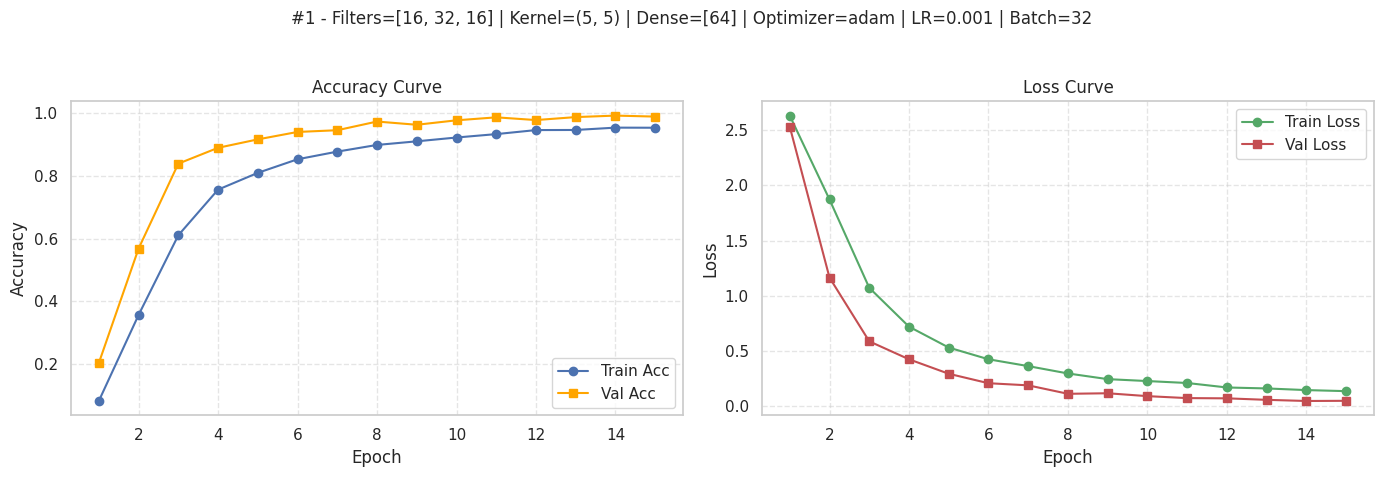

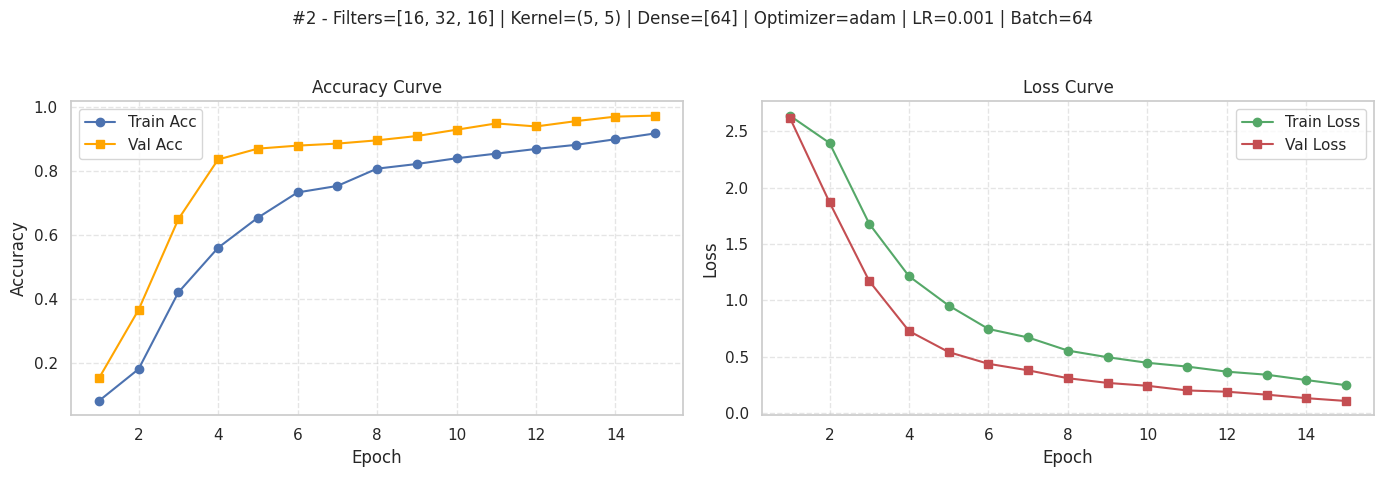

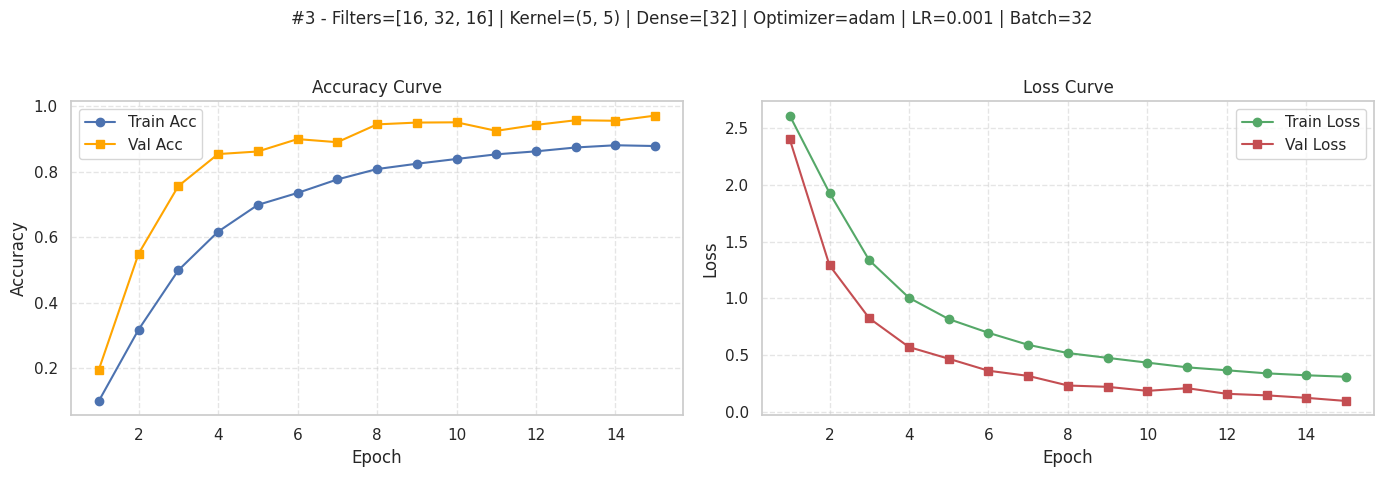

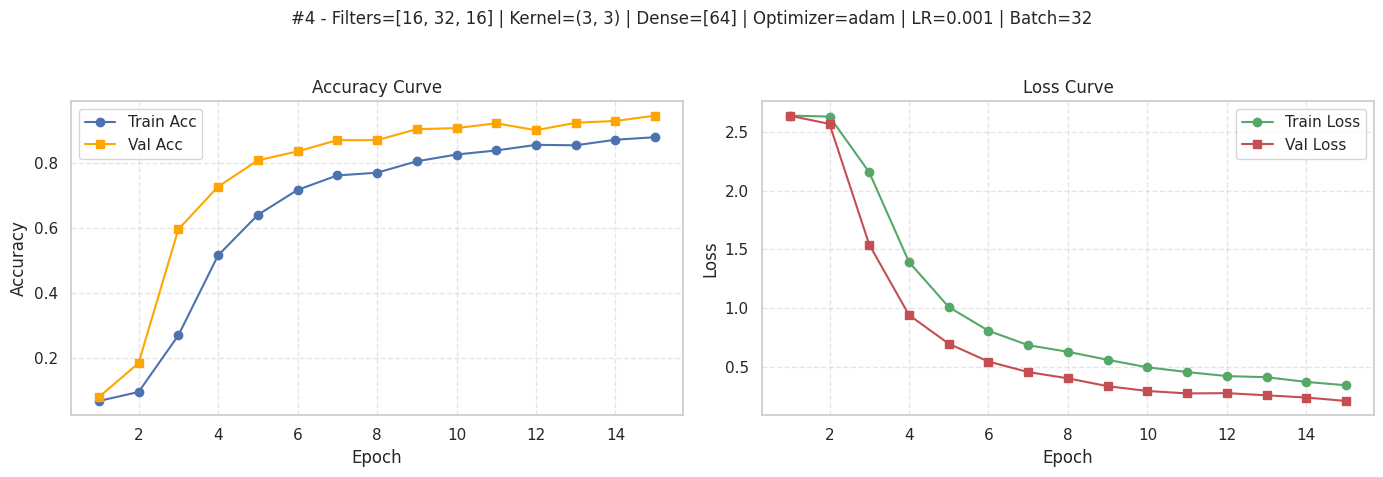

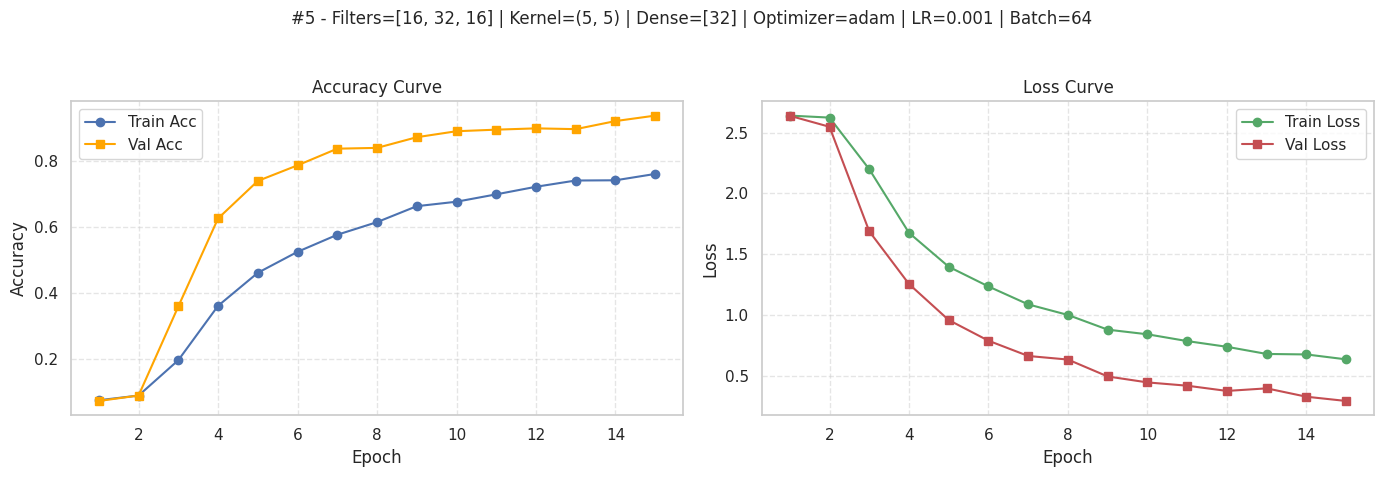

In [34]:
plot_all_training_histories(history_dicts, top_n=5)

In [ ]:
top5_configs = df_grid_results.sort_values(by='val_accuracy', ascending=False).head(5)
history_dicts = []

for i, row in top5_configs.iterrows():
    clf = FruitClassifier(
        input_shape=X_train.shape[1:],
        num_classes=len(class_names),
        num_filters=row['filters'],
        kernel_size=row['kernel'],
        pool_size=(2, 2),
        stride=row['stride'],
        padding='same',
        activation='relu',
        dense_units=row['dense'],
        dropout_rate=0.3,
        learning_rate=row['lr'],
        optimizer_name=row['optimizer']
    )

    clf.build_cnn_model()
    clf.compile_model()
    history = clf.train_cnn_model(
        X_train, y_train, X_val, y_val,
        epochs=15, batch_size=row['batch_size'], patience=3
    )

    history_dicts.append({
        'config': {
            'filters': row['filters'],
            'kernel': row['kernel'],
            'dense': row['dense'],
            'stride': row['stride'],
            'optimizer': row['optimizer'],
            'lr': row['lr'],
            'batch_size': row['batch_size']
        },
        'history': history.history
    })

NameError: name 'df_grid_results' is not defined

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_val, y_val, class_names):
    """
    Predict on validation set and plot confusion matrix.

    Parameters:
    - model: trained keras model
    - X_val: validation images
    - y_val: true labels
    - class_names: list of class names
    """
    # 1. 예측값 얻기
    y_pred = model.predict(X_val)
    y_pred_classes = y_pred.argmax(axis=1)

    # 2. Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred_classes)

    # 3. 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # 4. 텍스트 리포트
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

In [33]:
plot_confusion_matrix(classifier.model, X_val, y_val, class_names)

NameError: name 'classifier' is not defined